In [3]:
import os
os.environ['LD_LIBRARY_PATH'] = '$LD_LIBRARY_PATH:/home/kourosh/.mujoco/mujoco200/bin'

In [1]:
import d4rl
import gym
import numpy as np
import torch

from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

class PointmassBCDataset(Dataset):

    def __init__(self, name='maze2d-open-v0', block_size=64):
        
        self.block_size = block_size
        
        env = gym.make(name)
        self.data = env.get_dataset()
        self.obses = self.data['observations']
  
        self.acs = self.data['actions']
    
    
    def __len__(self):
        return len(self.obses) - self.block_size*2 - 1000

    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) characters from the data
        obses = self.obses[idx:idx + self.block_size]
        acs = self.acs[idx:idx + self.block_size]
        
        rand_id = np.random.randint(low=24, high=64)
        goal = self.obses[idx + self.block_size + rand_id: idx + self.block_size + rand_id + 1, :2]
        
        T = obses.shape[0]
        
        x = torch.tensor(obses, dtype=torch.float)
        goal = torch.tensor(goal, dtype=torch.float)
        goal = goal.repeat(T, 1)
        
        x = torch.cat([x, goal], -1)
        y = torch.tensor(acs, dtype=torch.float)
        
        return x, y
    
dataset = PointmassBCDataset(block_size=64)

loader = DataLoader(dataset, shuffle=True, pin_memory=True,
                                batch_size=64,
                                num_workers=4)


UnregisteredEnv: No registered env with id: maze2d-open-v0

In [5]:
obs, acs = next(iter(loader))
print(obs.shape, acs.shape)

NameError: name 'loader' is not defined

In [30]:
import hydra
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

import utils

# DT-related packages
import transformers

from decision_transformer.models.model import TrajectoryModel
from decision_transformer.models.trajectory_gpt2 import GPT2Model

class DecisionTransformer(TrajectoryModel):

    """
    This model uses GPT to model (state_1, state_2, ...)
    """

    def __init__(
            self,
            state_dim,
            act_dim,
            hidden_size,
            max_length=None,
            max_ep_len=4096,
            action_tanh=True,
            task_ver=0, 
            task_out=1,
            **kwargs
    ):
        super().__init__(state_dim, act_dim, max_length=max_length)

        self.hidden_size = hidden_size
        config = transformers.GPT2Config(
            vocab_size=1,  # doesn't matter -- we don't use the vocab
            n_embd=hidden_size,
            **kwargs
        )

        # note: the only difference between this GPT2Model and the default Huggingface version
        # is that the positional embeddings are removed (since we'll add those ourselves)
        self.transformer = GPT2Model(config)

        self.embed_timestep = nn.Embedding(max_ep_len, hidden_size)
        self.embed_state = torch.nn.Linear(self.state_dim, hidden_size)
        self.embed_ln = nn.LayerNorm(hidden_size)
        
        self.predict_action = nn.Sequential(
            *([nn.Linear(hidden_size, self.act_dim)])
        )
        
        # fine-tuning parameters
        self.task_ver = task_ver
        self.task_out = task_out

    def forward(self, states, timesteps=None, attention_mask=None):

        batch_size, seq_length = states.shape[0], states.shape[1]

        if attention_mask is None:
            # attention mask for GPT: 1 if can be attended to, 0 if not
            attention_mask = torch.ones((batch_size, seq_length), dtype=torch.long)

        # embed each modality with a different head
        # states: B x T x s_dim
        # timesteps: B x T
        # s_emb: B x T x hidden_size
        # t_emb: B x T x hidden_size
        state_embeddings = self.embed_state(states)
        # KM: time_embeddings = self.embed_timestep(timesteps)
        
        # time embeddings are treated similar to positional embeddings
        # KM: state_embeddings = state_embeddings + time_embeddings
        
        # this makes the sequence look like (s_1, s_2, s_3, ...)
        normalized_inputs = self.embed_ln(state_embeddings)

        # we feed in the input embeddings (not word indices as in NLP) to the model
        # attention_mask: B x T
        transformer_outputs = self.transformer(
            inputs_embeds=normalized_inputs,
            attention_mask=attention_mask,
        )
        x = transformer_outputs['last_hidden_state']

        # get predictions
        # x: B x T x hidden_size
        # act_pred: B x T x act_dim
        action_preds = self.predict_action(x)  # predict next action given state

        return action_preds
    
    def forward_freeze(self, states, task_embed, timesteps=None, attention_mask=None):

        batch_size, seq_length = states.shape[0], states.shape[1]

        if attention_mask is None:
            # attention mask for GPT: 1 if can be attended to, 0 if not
            attention_mask = torch.ones((batch_size, seq_length), dtype=torch.long)

        # embed each modality with a different head
        # states: B x T x s_dim
        # timesteps: B x T
        # s_emb: B x T x hidden_size
        # t_emb: B x T x hidden_size
        state_embeddings = self.embed_state(states)
        task_embed = task_embed.reshape(task_embed.shape[0], self.task_out, -1)
        if self.task_ver == 0:            
            state_embeddings = torch.cat([task_embed, state_embeddings], dim=1)
            # this makes the sequence look like (s_1, s_2, s_3, ...)
            normalized_inputs = self.embed_ln(state_embeddings)
        elif self.task_ver == 1:
            # this makes the sequence look like (s_1, s_2, s_3, ...)
            normalized_inputs = self.embed_ln(state_embeddings)
            normalized_inputs = torch.cat([task_embed, normalized_inputs], dim=1)
        elif self.task_ver == 2:
            task_embed = task_embed.repeat(1, state_embeddings.shape[1], 1)
            state_embeddings += task_embed 
            # this makes the sequence look like (s_1, s_2, s_3, ...)
            normalized_inputs = self.embed_ln(state_embeddings)
        elif self.task_ver == 3:
            task_embed = task_embed.repeat(1, state_embeddings.shape[1], 1)
            # this makes the sequence look like (s_1, s_2, s_3, ...)
            normalized_inputs = self.embed_ln(state_embeddings)
            normalized_inputs += task_embed
        # we feed in the input embeddings (not word indices as in NLP) to the model
        # attention_mask: B x T
        transformer_outputs = self.transformer(
            inputs_embeds=normalized_inputs,
            attention_mask=attention_mask,
        )
        x = transformer_outputs['last_hidden_state']

        # get predictions
        # x: B x T x hidden_size
        # act_pred: B x T x act_dim
        action_preds = self.predict_action(x)  # predict next action given state

        return action_preds

class Encoder(nn.Module):
    def __init__(self, obs_shape):
        super().__init__()

        assert len(obs_shape) == 3
        self.repr_dim = 32 * 35 * 35

        self.convnet = nn.Sequential(nn.Conv2d(obs_shape[0], 32, 3, stride=2),
                                     nn.ReLU(), nn.Conv2d(32, 32, 3, stride=1),
                                     nn.ReLU(), nn.Conv2d(32, 32, 3, stride=1),
                                     nn.ReLU(), nn.Conv2d(32, 32, 3, stride=1),
                                     nn.ReLU())

        self.apply(utils.weight_init)

    def forward(self, obs):
        obs = obs / 255.0 - 0.5
        h = self.convnet(obs)
        h = h.view(h.shape[0], -1)
        return h


class Actor(nn.Module):
    def __init__(self, obs_type, obs_dim, action_dim, feature_dim, hidden_dim, 
                 task_ver=0, task_out=1):
        super().__init__()

        feature_dim = feature_dim if obs_type == 'pixels' else hidden_dim
        
        # make DT
        self.policy = DecisionTransformer(
            state_dim=obs_dim, 
            act_dim=action_dim,
            max_ep_len=1000,
            hidden_size=128,
            n_layer=3,
            n_head=1,
            n_inner=4*128,
            activation_function='relu',
            task_ver=task_ver, 
            task_out=task_out,
            n_positions=1024,
            resid_pdrop=0.1,
            attn_pdrop=0.1,
        )
        
        self.apply(utils.weight_init)
    
    def forward(self, obs, mask, std):
        
        # obs (B, T, C) goal (B, 1, C)
        
        mu = self.policy(obs, attention_mask=mask)
        mu = mu[:,-1]
        mu = torch.tanh(mu)
        std = torch.ones_like(mu) * std

        dist = utils.TruncatedNormal(mu, std)
        return dist
    
    def forward_freeze(self, obs, task, mask, std):
        
        mu = self.policy.forward_freeze(obs, task, attention_mask=mask)
        mu = mu[:,-1]
        mu = torch.tanh(mu)
        std = torch.ones_like(mu) * std

        dist = utils.TruncatedNormal(mu, std)
        return dist


In [31]:
actor = Actor('states',6,2,128,128)

obs, acs = next(iter(loader))
print(obs.shape, acs.shape)
std = 0.025
B, T, _ = obs.shape
mask = torch.ones((B, T))

goal = obs[:,-1:,:]
print(goal.shape)
actor.forward(obs, mask, std)

torch.Size([64, 64, 6]) torch.Size([64, 64, 2])
torch.Size([64, 1, 6])


TruncatedNormal(loc: torch.Size([64, 2]), scale: torch.Size([64, 2]))

In [32]:
import tqdm 

model = Actor('states',6,2,128,128)

stddev_clip = 0.3
weight_decay=1e-4
learning_rate=1e-4
betas=(0.99,0.999)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=betas)

device = torch.device('cuda')

model = model.to(device)

losses = []
epochs = 10

mask = mask.to(device)

for epoch in range(epochs):
    pbar = tqdm.tqdm(enumerate(loader), total=len(loader)) if True else enumerate(loader)

    for it, (x, y) in pbar:

        # place data on the correct device
        x = x.to(device).float()

        target = y[:,-1,:].to(device).float()
        
        try:
            # forward the model
            with torch.set_grad_enabled(True):

                dist = model.forward(x, mask, std)
                action = dist.sample(clip=stddev_clip)

                log_prob = dist.log_prob(target).sum(-1, keepdim=True)

                error = (.5*(action - target)**2).mean()
                loss = - log_prob
                loss = loss.mean() # collapse all losses if they are scattered on multiple gpus
                losses.append(loss.item())
                model.zero_grad()
                loss.backward()
                optimizer.step()
        except:
            print('it',it,'err')
        if it % 1000 == 0:
            print(loss.item(), error.item())

        #if it == 5000:
        #    break


  0%|          | 8/15608 [00:00<11:31, 22.55it/s]  

2026.3984375 0.6381360292434692


  6%|▋         | 1006/15608 [00:18<04:49, 50.44it/s]

457.813720703125 0.14457407593727112


 13%|█▎        | 2010/15608 [00:39<04:46, 47.42it/s]

364.49078369140625 0.11614827811717987


 19%|█▉        | 3011/15608 [00:58<02:59, 70.24it/s]

277.0807189941406 0.08881668746471405


 26%|██▌       | 4012/15608 [01:13<02:42, 71.57it/s]

160.85708618164062 0.05248843878507614


 32%|███▏      | 5015/15608 [01:28<02:28, 71.12it/s]

198.02316284179688 0.06275854259729385


 38%|███▊      | 6009/15608 [01:43<02:16, 70.34it/s]

282.99700927734375 0.08997822552919388


 45%|████▍     | 7007/15608 [01:59<02:36, 55.09it/s]

251.5409698486328 0.08274805545806885


 51%|█████▏    | 8015/15608 [02:13<01:50, 68.85it/s]

151.33741760253906 0.0491676852107048


 58%|█████▊    | 9008/15608 [02:28<01:37, 67.36it/s]

118.37098693847656 0.038675326853990555


 64%|██████▍   | 10015/15608 [02:44<01:18, 70.89it/s]

218.7628631591797 0.06948371231555939


 71%|███████   | 11013/15608 [02:59<01:07, 68.17it/s]

162.37973022460938 0.05365936458110809


 77%|███████▋  | 12013/15608 [03:18<00:51, 69.73it/s]

170.7465362548828 0.055464718490839005


 83%|████████▎ | 13008/15608 [03:32<00:37, 69.78it/s]

187.70758056640625 0.06196833774447441


 90%|████████▉ | 14011/15608 [03:47<00:23, 68.30it/s]

255.72601318359375 0.08124357461929321


 96%|█████████▌| 15013/15608 [04:02<00:09, 62.70it/s]

140.64889526367188 0.046147823333740234


100%|██████████| 15608/15608 [04:12<00:00, 61.87it/s]

it 15607 err



  0%|          | 8/15608 [00:00<07:12, 36.06it/s]

155.44287109375 0.051083892583847046


  6%|▋         | 1012/15608 [00:16<03:13, 75.39it/s]

184.68939208984375 0.059138160198926926


 13%|█▎        | 2015/15608 [00:30<03:13, 70.43it/s]

113.31416320800781 0.03859151154756546


 19%|█▉        | 3011/15608 [00:49<04:01, 52.26it/s]

164.55429077148438 0.05314319208264351


 26%|██▌       | 4008/15608 [01:05<03:33, 54.39it/s]

215.08651733398438 0.06786573678255081


 32%|███▏      | 5011/15608 [01:20<02:35, 68.07it/s]

197.39425659179688 0.06361620128154755


 39%|███▊      | 6015/15608 [01:34<02:17, 70.01it/s]

196.57757568359375 0.06394390016794205


 45%|████▍     | 7008/15608 [01:49<02:05, 68.27it/s]

249.1422119140625 0.07893344759941101


 51%|█████▏    | 8014/15608 [02:04<01:49, 69.50it/s]

138.3106689453125 0.0459689125418663


 58%|█████▊    | 9012/15608 [02:19<01:48, 60.74it/s]

118.0503921508789 0.040456146001815796


 64%|██████▍   | 10009/15608 [02:33<01:23, 67.36it/s]

114.81010437011719 0.038436293601989746


 71%|███████   | 11010/15608 [02:48<01:09, 66.04it/s]

154.0453338623047 0.050135981291532516


 77%|███████▋  | 12009/15608 [03:06<01:14, 48.54it/s]

59.192893981933594 0.020324932411313057


 83%|████████▎ | 13010/15608 [03:22<00:37, 68.42it/s]

149.7607879638672 0.049818601459264755


 90%|████████▉ | 14009/15608 [03:37<00:22, 71.42it/s]

118.31501770019531 0.038660552352666855


 96%|█████████▌| 15015/15608 [03:51<00:08, 71.22it/s]

204.36917114257812 0.06524370610713959


100%|██████████| 15608/15608 [04:00<00:00, 64.93it/s]

it 15607 err



  0%|          | 13/15608 [00:00<04:09, 62.50it/s]

193.09942626953125 0.06250199675559998


  6%|▋         | 1007/15608 [00:14<04:38, 52.48it/s]

123.16639709472656 0.04014779254794121


 13%|█▎        | 2008/15608 [00:35<04:51, 46.58it/s]

69.21067810058594 0.02451074682176113


 19%|█▉        | 3008/15608 [00:51<03:03, 68.61it/s]

133.28817749023438 0.044082824140787125


 26%|██▌       | 4014/15608 [01:06<02:43, 70.89it/s]

161.81190490722656 0.053437113761901855


 32%|███▏      | 5013/15608 [01:20<02:32, 69.55it/s]

121.98905181884766 0.04094785824418068


 39%|███▊      | 6014/15608 [01:36<02:24, 66.42it/s]

148.29771423339844 0.047598063945770264


 45%|████▍     | 7013/15608 [01:53<02:03, 69.70it/s]

124.62644958496094 0.04112996533513069


 51%|█████▏    | 8010/15608 [02:07<01:46, 71.50it/s]

113.071044921875 0.03674197569489479


 56%|█████▌    | 8746/15608 [02:17<01:34, 72.72it/s]

it 8739 err


 56%|█████▌    | 8748/15608 [02:22<01:51, 61.44it/s]


RuntimeError: DataLoader worker (pid(s) 71759, 71760, 71761, 71762) exited unexpectedly

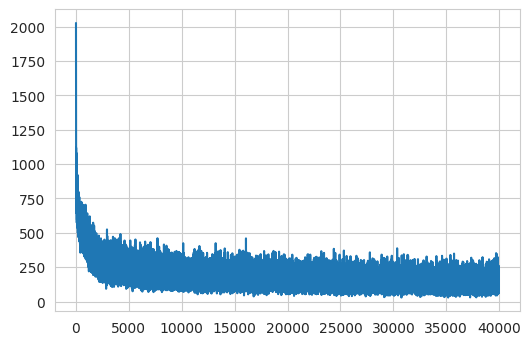

In [33]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [34]:
dataset = PointmassBCDataset(block_size=128)

loader = DataLoader(dataset, shuffle=True, pin_memory=True,
                                batch_size=64,
                                num_workers=4)

load datafile: 100%|██████████| 8/8 [00:00<00:00, 27.13it/s]


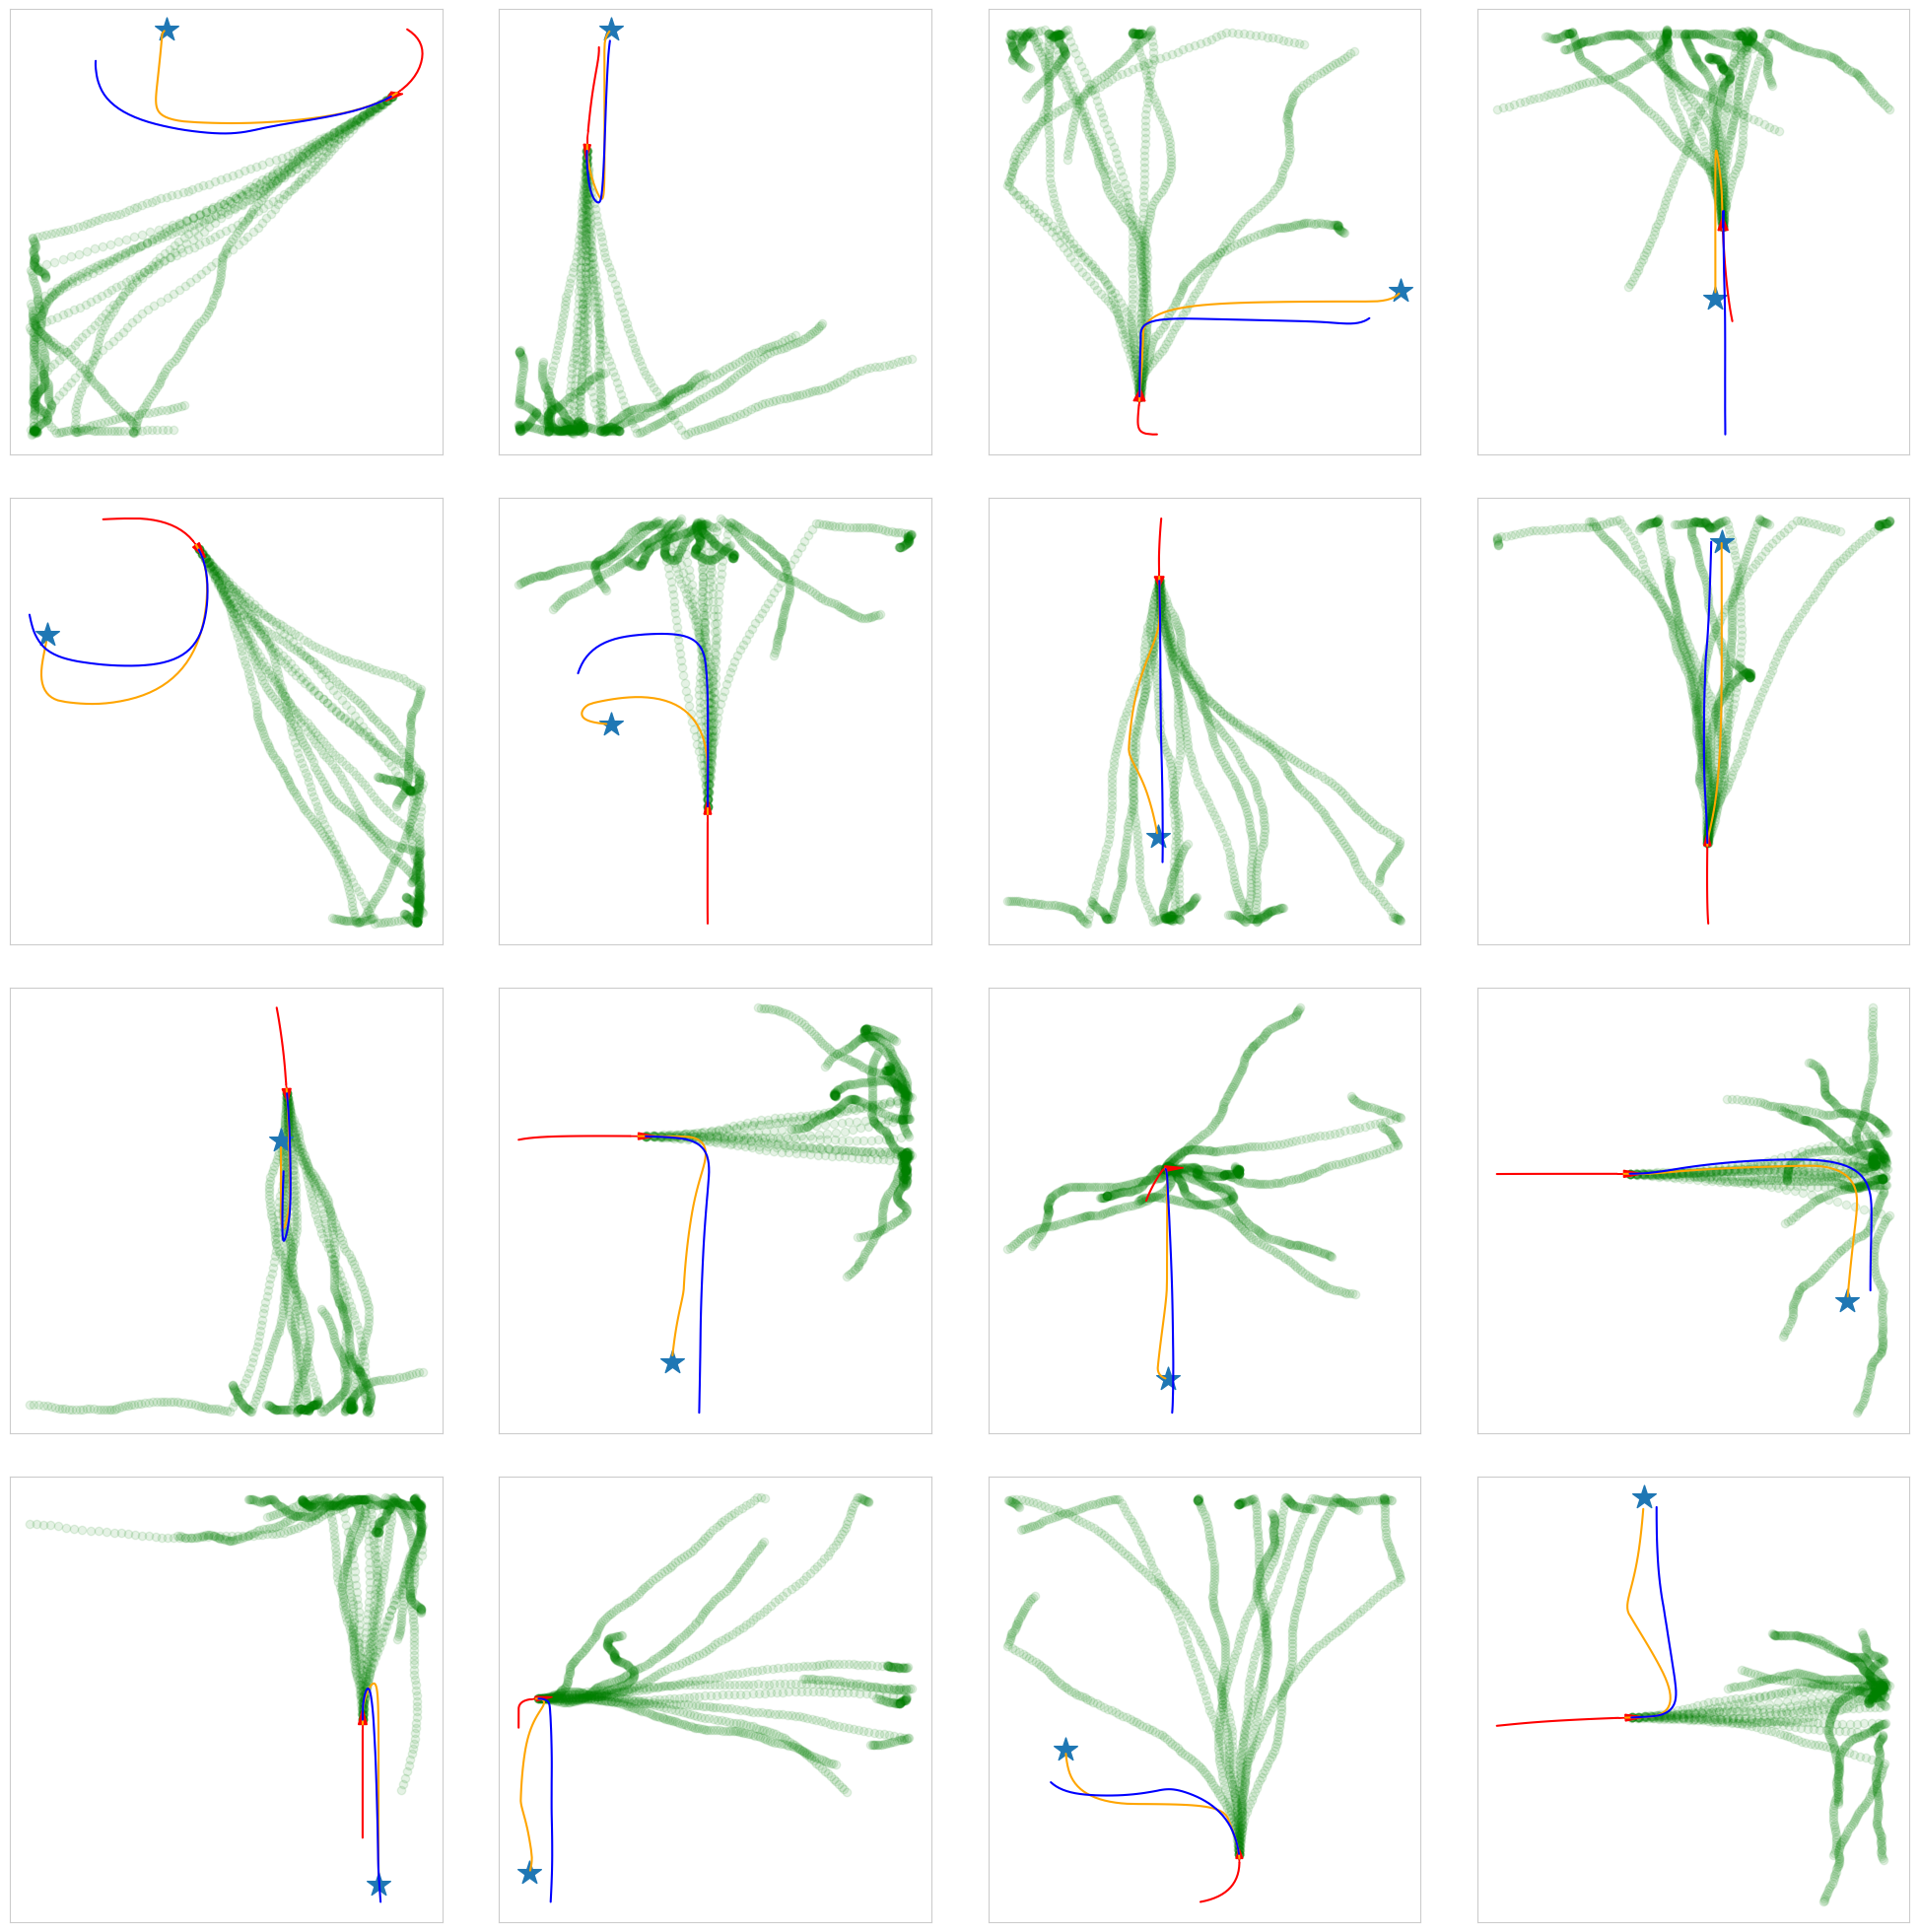

In [35]:
env = gym.make('maze2d-open-v0')

x, y = next(iter(loader))

x = x.to(device).float()

steps = 120

fig, axs = plt.subplots(4,4, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.tight_layout()
axs = axs.ravel()

mid = 64


# 12 21 28 29 33 34
for idx in range(16):

    
    qpos = x[idx][mid][:2].detach().cpu().numpy()
    qvel = x[idx][mid][2:4].detach().cpu().numpy()
    
    goal = x[idx][steps][:2]

    env.reset()
    env.set_state(qpos,qvel)

    rand = []
    # random exploration 
    for _ in range(10):
        env.reset()
        env.set_state(qpos,qvel)

        for _ in range(steps):
            s, r, d, _ = env.step(env.action_space.sample())
            rand.append(s[:2])
    
    osil = []
    goals = []
    
    for _ in range(1):
        env.reset()
        env.set_state(qpos,qvel)
        seq = x[idx,:mid,:][None,...] #.detach().cpu().numpy()
        
      
        seq[:,:,-2:] = goal
        goals.append(goal.detach().cpu().numpy())
      
        for i in range(steps - mid):
            
            
            dist = model.forward(seq, mask[:1,:], 0.001)
            ac = dist.sample().squeeze(0)
       
            
            s, r, d, _ = env.step(ac.detach().cpu().numpy())
            osil.append(s[:2])
            s = torch.as_tensor(s, dtype=x.dtype, device= x.device)
            
            sgoal = torch.cat([s[None,None,:], goal[None,None,:]], -1)
            
            seq = torch.cat([seq, sgoal], 1)
        
            seq = seq[:,-64:,:]
    
    osil = np.array(osil)
    
    rand = np.array(rand)
    
    goals = np.array(goals).squeeze(0)
    
    px = x.detach().cpu().numpy()

    axs[idx].scatter(rand[:,0], rand[:,1], c='g',alpha=0.1)
    axs[idx].plot(x[idx,mid-16:mid,0].detach().cpu().numpy(), x[idx,mid - 16:mid,1].detach().cpu().numpy(),c='red')
    
    ardir = [px[idx,mid,0] - px[idx,mid - 1,0], px[idx,mid,1] - px[idx,mid - 1,1]]
    axs[idx].arrow(px[idx,mid - 1,0], px[idx,mid - 1,1], ardir[0], ardir[1], head_width=0.05, head_length=0.1,color='red')

    axs[idx].plot(x[idx,mid:steps,0].detach().cpu().numpy(), x[idx,mid:steps,1].detach().cpu().numpy(),c='orange')
    axs[idx].plot(osil[:steps,0], osil[:steps,1],c='b')
    
    axs[idx].scatter(goals[:1],goals[-1:], s=320, marker='*')
    
    axs[idx].set_xticks([])
    # for minor ticks
    axs[idx].set_xticks([], minor=True)
    axs[idx].set_yticks([])
    # for minor ticks
    axs[idx].set_yticks([], minor=True)



In [90]:
goals.shape

(1, 2)

In [121]:
model.policy

DecisionTransformer(
  (transformer): GPT2Model(
    (wte): Embedding(1, 128)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((128,), eps=1e-05, element

In [8]:
env = gym.make('maze2d-open-v0')
env.reset()

img = env.render(height=500,width=500,mode='rgb_array')

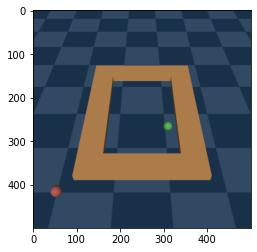

In [9]:
import matplotlib.pyplot as plt
plt.imshow(img)